In [5]:
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, device):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.01),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        ).to(device)

    def forward(self, x):
        return self.gen(x)

In [ ]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_dim, device):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        return self.disc(x)

In [ ]:
# Hyperparameters
lr = 0.0002
z_dim = 64  # Size of the noise vector
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize generator and discriminator
gen = Generator(z_dim, image_dim, device)
disc = Discriminator(image_dim, device)

In [ ]:
# Loss and optimizers
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST('~/.pytorch/MNIST_data/', transform=transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Training Loop
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(real)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim, device=device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        disc_optimizer.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        gen_optimizer.step()

        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] \t Loss D: {lossD:.4f}, loss G: {lossG:.4f}")


Epoch [0/50] 	 Loss D: 0.6935, loss G: 0.6791
Epoch [1/50] 	 Loss D: 0.1198, loss G: 3.6974
Epoch [2/50] 	 Loss D: 0.1468, loss G: 4.4236
Epoch [3/50] 	 Loss D: 0.2120, loss G: 3.3810
Epoch [4/50] 	 Loss D: 0.1823, loss G: 2.8035
Epoch [5/50] 	 Loss D: 0.2314, loss G: 2.1238
Epoch [6/50] 	 Loss D: 0.2957, loss G: 3.3819
Epoch [7/50] 	 Loss D: 0.2825, loss G: 2.1303
Epoch [8/50] 	 Loss D: 0.3632, loss G: 1.8318
Epoch [9/50] 	 Loss D: 0.6302, loss G: 1.6953
Epoch [10/50] 	 Loss D: 0.4953, loss G: 1.2108
Epoch [11/50] 	 Loss D: 0.5603, loss G: 1.4226
Epoch [12/50] 	 Loss D: 0.6395, loss G: 1.2752
Epoch [13/50] 	 Loss D: 0.4648, loss G: 1.2721
Epoch [14/50] 	 Loss D: 0.6095, loss G: 1.0257
Epoch [15/50] 	 Loss D: 0.6666, loss G: 0.9718
Epoch [16/50] 	 Loss D: 0.7078, loss G: 0.9582
Epoch [17/50] 	 Loss D: 0.5829, loss G: 1.2100
Epoch [18/50] 	 Loss D: 0.5880, loss G: 1.1103
Epoch [19/50] 	 Loss D: 0.4963, loss G: 1.1781
Epoch [20/50] 	 Loss D: 0.5317, loss G: 0.9811
Epoch [21/50] 	 Loss D:

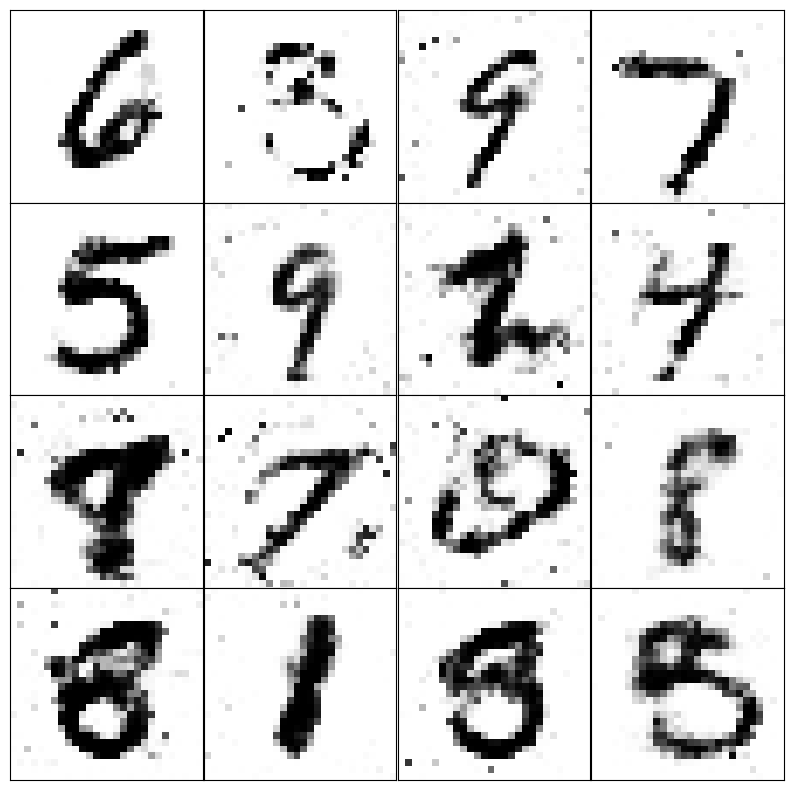

In [6]:
# Generate some images with the trained GAN
with torch.no_grad():
    # Generate noise vector
    test_noise = torch.randn(batch_size, z_dim, device=device)
    # Generate images from noise
    generated_images = gen(test_noise).view(-1, 1, 28, 28)
    # Move images to CPU and convert to numpy for visualization
    generated_images = generated_images.cpu().numpy()

# Plot the generated images
fig, axes = plt.subplots(figsize=(10, 10), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), generated_images):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='gray_r')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()